# Thesis Data Analysis

In [1]:
# read .csv
from svglib.svglib import svg2rlg

# computation & data structures
import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, abs, mean
import itertools
import pandas as pd
from typing import Callable, Tuple
import glob

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.graphics import renderPDF
import os
import shutil
from dataclasses import dataclass, field

import time
from matplotlib.animation import FuncAnimation
from IPython import display

## Map Data
Define functions for computing tilt, etc. for a given center-sample pair. Each point has an ID and coordinates (lat, lon). The sample point also has $\theta_1, \theta_2, \varphi_2$ but everything else is calculated.

In [2]:
MARS_EQ_RADIUS = 3396.2  # km


def dist(lat_sample, lon_sample, lat_center, lon_center):
    '''distance between pts 1 and 2'''
    lat1 = rad(lat_sample)
    lon1 = rad(lon_sample)
    lat2 = rad(lat_center)
    lon2 = rad(lon_center)
    rads = arccos(
        cos(lat1) * cos(lat2)
        * cos(lon2 - lon1)
        + sin(lat1) * sin(lat2)
    )
    return rads * MARS_EQ_RADIUS


def bearing(lat_sample, lon_sample, lat_center, lon_center):
    '''angle from pt 1 AWAY from pt 2'''
    lat1 = rad(lat_sample)
    lon1 = rad(lon_sample)
    lat2 = rad(lat_center)
    lon2 = rad(lon_center)
    y = sin(lon2 - lon1) * cos(lat2)
    x = cos(lat1) * sin(lat2) \
        - sin(lat1) * cos(lat2) * cos(lon2 - lon1)
    return (180 + deg(arctan2(y, x))) % 360


def beta(az, bearing):
    '''angular difference in [-180, +180]'''
    return ((az - bearing + 180) % 360) - 180


def sl1(beta1, beta2, sl2):
    beta1 = rad(beta1)
    beta2 = rad(beta2)
    sl2 = rad(sl2)
    arg = sin(beta2) * sin(sl2) / sin(beta1)
    if arg < 0 or arg > 1:  # not possible
        return np.nan
    else:
        sl1 = arcsin(arg)
        return deg(sl1)


def proj(beta, sl):
    beta = rad(beta)
    sl = rad(sl)
    proj = arctan(tan(beta) * cos(beta))
    return deg(proj)


def tilt(beta1, sl1, beta2, sl2):
    return proj(beta2, sl2) - proj(beta1, sl1)

Read samples.csv and centers.csv and extract point IDs for each.

In [3]:
# location to read .csv files
map_path = "../GEOL192-GIS/data/"


centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index(['sID', 'FEATURE'])

cIDs = tuple(centers.index)
sIDs = tuple(index[0] for index in samples.index)

Define an object to organize, calculate, and plot map data for a single center point.

In [48]:
@dataclass
class Center:
    cID: int

    def __post_init__(self):
        self.data = samples.copy()

        # this of course only works for unique self.cIDs
        self.latC = centers.loc[self.cID, 'LAT']
        self.lonC = centers.loc[self.cID, 'LON']
        self.calculate()

    def plot(self, name: str = None):  # type: ignore
        fig = plt.figure(figsize=(8, 5), dpi=600)

        sns.scatterplot(data=self.data, x='DIST', y='TILT')

        plt.title(f"Tilt from Center {self.cID}")
        plt.xlabel("Distance (km)")
        plt.ylabel("Tilt (deg)")

        # save plot with name if passed as argument
        if name is not None:
            fig.savefig("plot.svg")
            renderPDF.drawToFile(svg2rlg("plot.svg"), f"figures/{name}.pdf")
            os.remove("plot.svg")

    def calculate(self):

        self.data['DIST'] = self.data.apply(
            lambda row: dist(
                lat_sample=row['LAT'], lon_sample=row['LON'],
                lat_center=self.latC, lon_center=self.lonC
            ),
            axis=1
        )

        self.data['BEARING'] = self.data.apply(
            lambda row: bearing(
                lat_sample=row['LAT'], lon_sample=row['LON'],
                lat_center=self.latC, lon_center=self.lonC
            ),
            axis=1
        )

        self.data['BETA1'] = self.data.apply(
            lambda row: beta(
                az=row['AZ1'], bearing=row['BEARING']
            ),
            axis=1
        )

        self.data['BETA2'] = self.data.apply(
            lambda row: beta(
                az=row['AZ2'], bearing=row['BEARING']
            ),
            axis=1
        )

        self.data['SL1'] = self.data.apply(
            lambda row: sl1(
                beta1=row['BETA1'],
                beta2=row['BETA2'], sl2=row['SL2']
            ),
            axis=1
        )

        self.data['TILT'] = self.data.apply(
            lambda row: tilt(
                beta1=row['BETA1'], sl1=row['SL1'],
                beta2=row['BETA2'], sl2=row['SL2']
            ),
            axis=1
        )

Make an object for each center. This should take less than a minute.

In [5]:
centers_calc = [Center(cID) for cID in cIDs]

Define an object for sample populations of interest and make a few.

In [42]:
@dataclass
class Population:
    feature: tuple = ('flow', 'channel')
    name: str = ''
    sIDs: tuple = sIDs  # type: ignore


pops = [
    Population(),
    Population(('flow',)),
    Population(('channel',)),
    # these are wrong, will have to look for point IDs or go back to get linear feature Ids to inherit into samples.
    # Population(('flow',), 'SE', (49, 60, 61, 62, 63, 64, 85, 86, 87))
]

Define criteria for evaluating how well a center point explains a sample population.

In [9]:
@dataclass
class Criterion:
    func: Callable
    name: str


def evaluate(center: Center, pop: Population, crit: Criterion) -> float:
    return crit.func(center, pop)


def summit_score(center: Center, pop: Population):
    '''low is good: features point away from center'''
    df = center.data
    subset_beta1 = df.loc[(pop.sIDs, pop.feature), 'BETA1']
    return mean(abs(subset_beta1))

# FIXME
def inflation_score(center: Center, pop: Population):
    df = center.data
    subset_beta1 = df.loc[(pop.sIDs, pop.feature), 'BETA1']
    return mean(abs(subset_beta1))


criteria = [Criterion(summit_score, 'summit_score')]  # needs to be an iterable

Evalulate each center using each combination of criterion and sample population.

In [10]:
# TODO: cleanup
full_dict = {}
score_name_list = []

for pop in pops:
    for crit in criteria:
        name = f'{pop.feature}_{pop.name}_{crit.name}'
        name = name.replace("__", "_") # cleanup string
        name = name.replace("(", "")
        name = name.replace(")", "")
        name = name.replace(",", "")
        name = name.replace("'", "")
        name = name.replace("flow channel_", "")
        score_name_list.append(name)

for center in centers_calc:
    cID = center.cID
    center_list = []
    for pop in pops:
        for crit in criteria:
            center_list.append(evaluate(center, pop, crit))
    full_dict[center.cID] = center_list

Append evaluated scores and export for importing back into GIS.

In [43]:
scores = pd.DataFrame(full_dict).transpose().set_axis(score_name_list, axis=1)

centers_eval = pd.concat((centers, scores), axis=1)

# easy to concat multiple times; this removes any duplicate columns
centers_eval = centers_eval.loc[:, ~centers_eval.columns.duplicated()]  # type: ignore

centers_eval.to_csv('centers_eval.csv')

## Numerical Model Data

Read initial positions and displacement vectors (radial and vertical components) of mesh nodes.

In [12]:
model_data_location = "../GEOL192-Model/data/"

topo = np.genfromtxt(f'{model_data_location}z1.csv', delimiter=",")


def model_pos1_from_csv(name: str):
    r = np.genfromtxt(model_data_location + "r_" + name, delimiter=",")[:, 0]
    z = np.interp(r, *topo.T, right=0)
    return np.array([r, z]).T


def model_disp_from_csv(name: str):
    r = np.genfromtxt(f'{model_data_location}r_{name}', delimiter=",")[:, 1]
    z = np.genfromtxt(f'{model_data_location}z_{name}', delimiter=",")[:, 1]
    return np.array([r, z]).T

Define constants:

In [44]:
# constants in SI units
SHEAR_MODULUS = 2.4e10
ROCK_DENSITY = 2700
MAGMA_DENSITY = 2700
MARS_GRAVITY = 3.72
PLOT_WIDTH = 200_000

Define analytical solution (elastic half-space inflated by spherical reservoir) for comparison.

In [14]:
@dataclass
class MogiModel:
    dP: float
    radius: float
    DtC: float
    r1: np.array  # type: ignore

    def disp(self) -> np.array:  # type: ignore
        common = 3 * self.radius**3 * self.dP / \
            (4 * SHEAR_MODULUS * (self.DtC**2 + self.r1**2)**1.5)
        rdisp = common * self.r1
        zdisp = common * self.DtC
        return np.array(rdisp, zdisp)

    def tilt(self) -> np.array:  # type: ignore
        a = 3 * self.radius**3 * self.dP / (4 * SHEAR_MODULUS)
        num = 3 * a * self.DtC * self.r1
        denom = (self.DtC**2 + self.r1**2)**2.5 + \
            a * self.DtC**2 - 2 * a * self.r1**2
        return deg(arctan2(num, denom))

Define objects for displaced nodes and surface elements (the latter defined by a consecutive pair of the former). Tilt calculation in the element class.

In [45]:
@dataclass
class Node:
    pos1: Tuple[float, float]
    disp: Tuple[float, float]

    def __post_init__(self):
        self.pos2 = self.pos1 + self.disp


@dataclass
class Element:
    proximal: Node  # (A in text)
    distal: Node  # (B in text)

    def __post_init__(self):
        # relative dimensions [r, z] of initial and displaced segments
        self.shape1 = self.distal.pos1 - self.proximal.pos1  # type: ignore
        self.shape2 = self.distal.pos2 - self.proximal.pos2  # type: ignore

        # mean position of initial and displaced segments
        self.pos1 = (self.distal.pos1 + self.proximal.pos1) / 2  # type: ignore
        self.pos2 = (self.distal.pos2 + self.proximal.pos2) / 2  # type: ignore

        # radial distances for plotting
        self.r1_km = self.pos1[0] / 1000
        self.r2_km = self.pos2[0] / 1000

        # initial and displaced slopes (positive downward from center)
        # index [1] is z component; [0] is r component
        self.slope1 = deg(arctan2(-self.shape1[1], self.shape1[0]))
        self.slope2 = deg(arctan2(-self.shape2[1], self.shape2[0]))

        self.tilt = self.slope2 - self.slope1

Define model class with parameter combination (geometry, overpressure). It reads .csv files, builds nodes & elements, etc.

In [24]:
class Model:
    def __init__(self, params: dict):

        self.params = params

        self.dP = params['pmult'] * params['DtT'] * ROCK_DENSITY * MARS_GRAVITY

        filename = f"DtT_{params['DtT']}_resr_{params['resr']}_pmult_{params['pmult']}_gmult_{int(params['grav'])}_zmult_{int(params['topo'])}_resaspect_{params['aspect']}.csv"

        # read initial positions and displacements
        self.pos1 = model_pos1_from_csv(filename)
        self.disp = model_disp_from_csv(filename)

        # subtract out gravitational component (with no overpressure)
        if params['grav']:
            filename_p0 = filename.replace(
                f"pmult_{params['pmult']}", "pmult_0")
            self.disp -= model_disp_from_csv(filename_p0)

        # make z1 flat for flat model
        if not params['topo']:
            self.pos1[1] = np.zeros(len(self.pos1[1]))

        # build nodes from pos1 and disp if pos1 within defined length
        self.num_nodes = next(i for i, val in enumerate(self.pos1)
                              if val[0] > PLOT_WIDTH)

        self.nodes = [Node(self.pos1[i], self.disp[i])
                      for i in range(self.num_nodes)]

        # build elements from consecutive node pairs
        self.node_pairs = zip(self.nodes[:-1], self.nodes[1:])
        self.elements = [Element(*pair) for pair in self.node_pairs]

        # put element attributes into dict of lists
        self.attributes = pd.DataFrame(
            [vars(element) for element in self.elements]).to_dict("list")

        # include analytical comparison if spherical assumption is met (topography is less important but technically violates assumptions)
        if params['aspect'] == 1:
            self.mogi_tilt = MogiModel(
                dP=self.dP,
                radius=params['resr'],
                DtC=params['DtT'] + params['resr'],
                r1=self.attributes['r1_km']).tilt()

Define parametric sweep class to mirror COMSOL iterative modelling. It makes a Model class out of each geometry and defines a plot method which displays constant and varied parameters within the sweep.

In [46]:
# parameter sweep in SI units (to match csv output from COMSOL)
class ParamSweep:
    def __init__(self, params: dict):

        # define constant parameters for labelling once in title
        self.constants = {key: val[0]
                          for key, val in params.items() if len(val) == 1}

        # define variable parameters for labelling individually
        self.variables = [key for key, val in params.items() if len(val) > 1]

        self.models = [Model(dict(zip(params, item)))
                       for item in itertools.product(*params.values())]

    def plot(self, name: str = None):  # type: ignore
        fig = plt.figure(figsize=(8, 5), dpi=600)

        for model in self.models:
            label = '{}'.format({param: model.params[param] for param in self.variables})
            label = label.replace("{", "")
            label = label.replace("}", "")
            label = label.replace("'", "")
            sns.lineplot(data=model.attributes, y="tilt", x="r2_km", label=label)

        title = f'{self.constants}'
        title = title.replace("{", "")
        title = title.replace("}", "")
        title = title.replace("'", "")
        plt.title(f"Radial Tilt: {title}")
        plt.xlabel("Distance (km)")
        plt.ylabel("Tilt (deg)")
        plt.legend(loc="upper right")

        # save plot with name if passed as argument
        if name is not None:
            fig.savefig("plot.svg")
            renderPDF.drawToFile(svg2rlg("plot.svg"), f"figures/{name}.pdf")
            os.remove("plot.svg")


test_sweep = ParamSweep({
    "DtT": [10_000, 12_000],  # 10_000
    "resr": [30_000],
    "aspect": [.5],
    "pmult": [0.6],
    "grav": [False],  # 0, 1
    "topo": [True]  # 0, 1
})

full_sweep = ParamSweep({
    "DtT": [14_000],  # 10_000
    "resr": [30_000],
    "aspect": [.5],
    "pmult": [0.2, 0.6],
    "grav": [False],
    "topo": [True]
})

# Plotting

Finally, I plot numerical model outputs:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


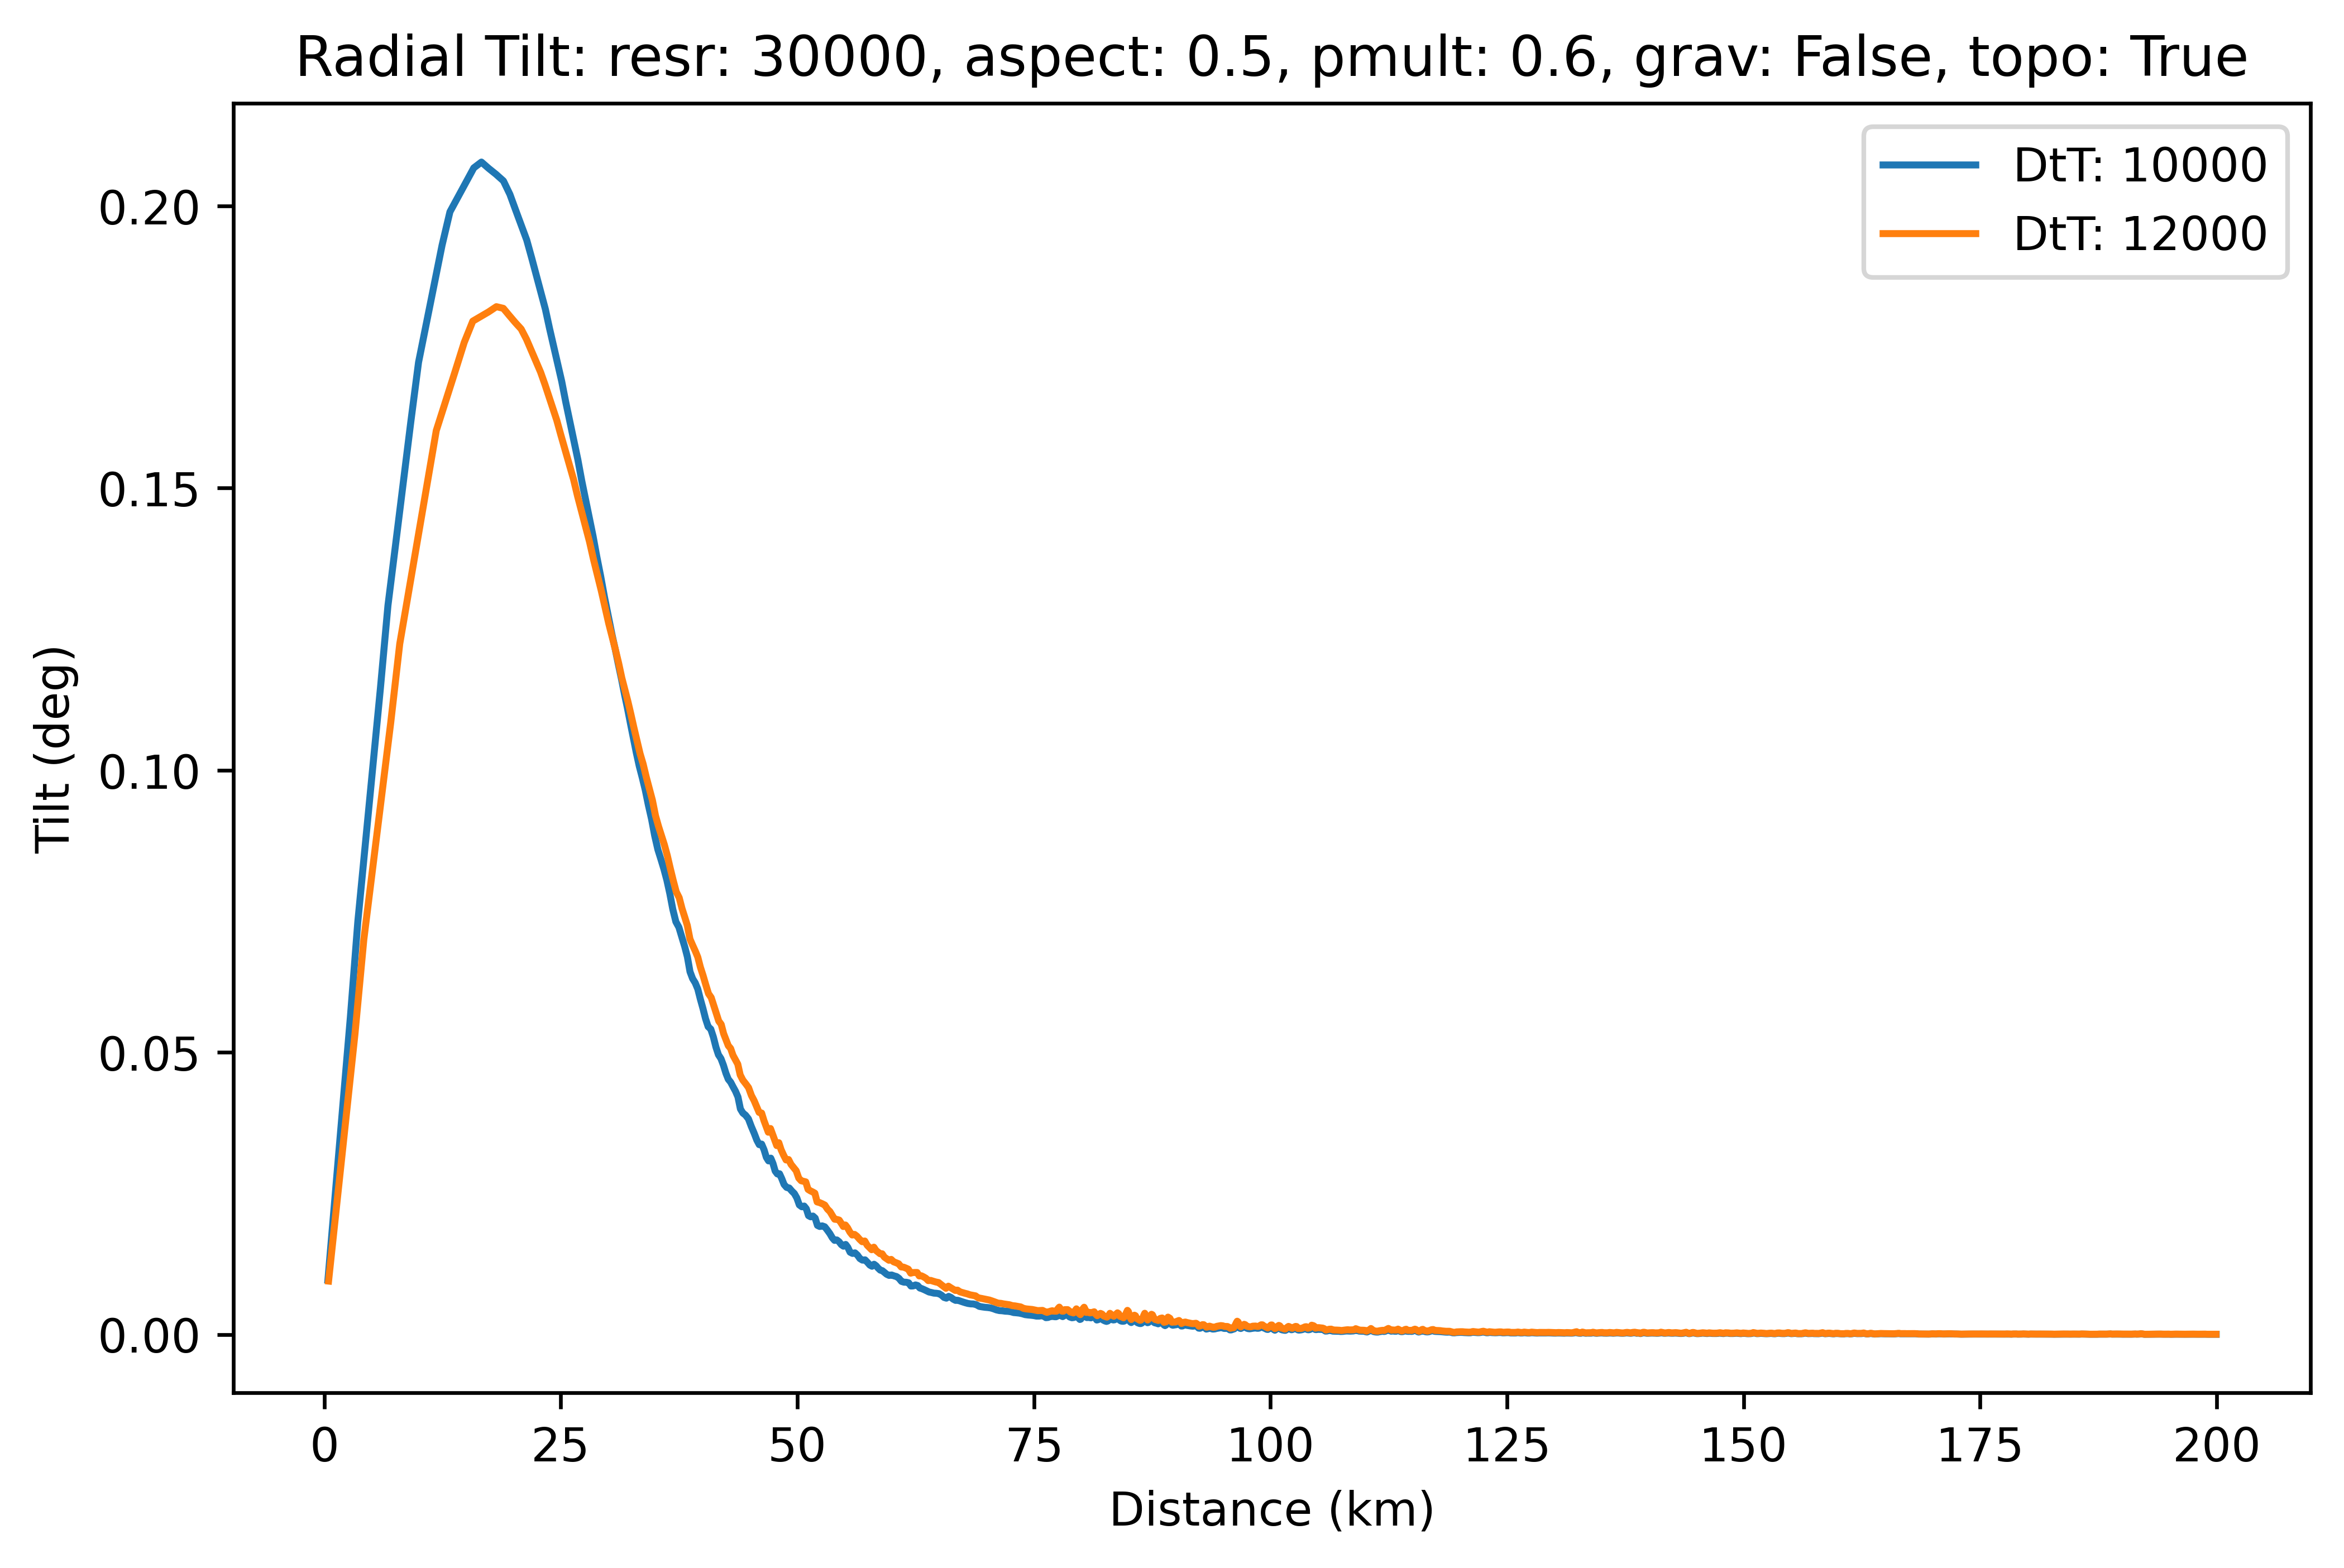

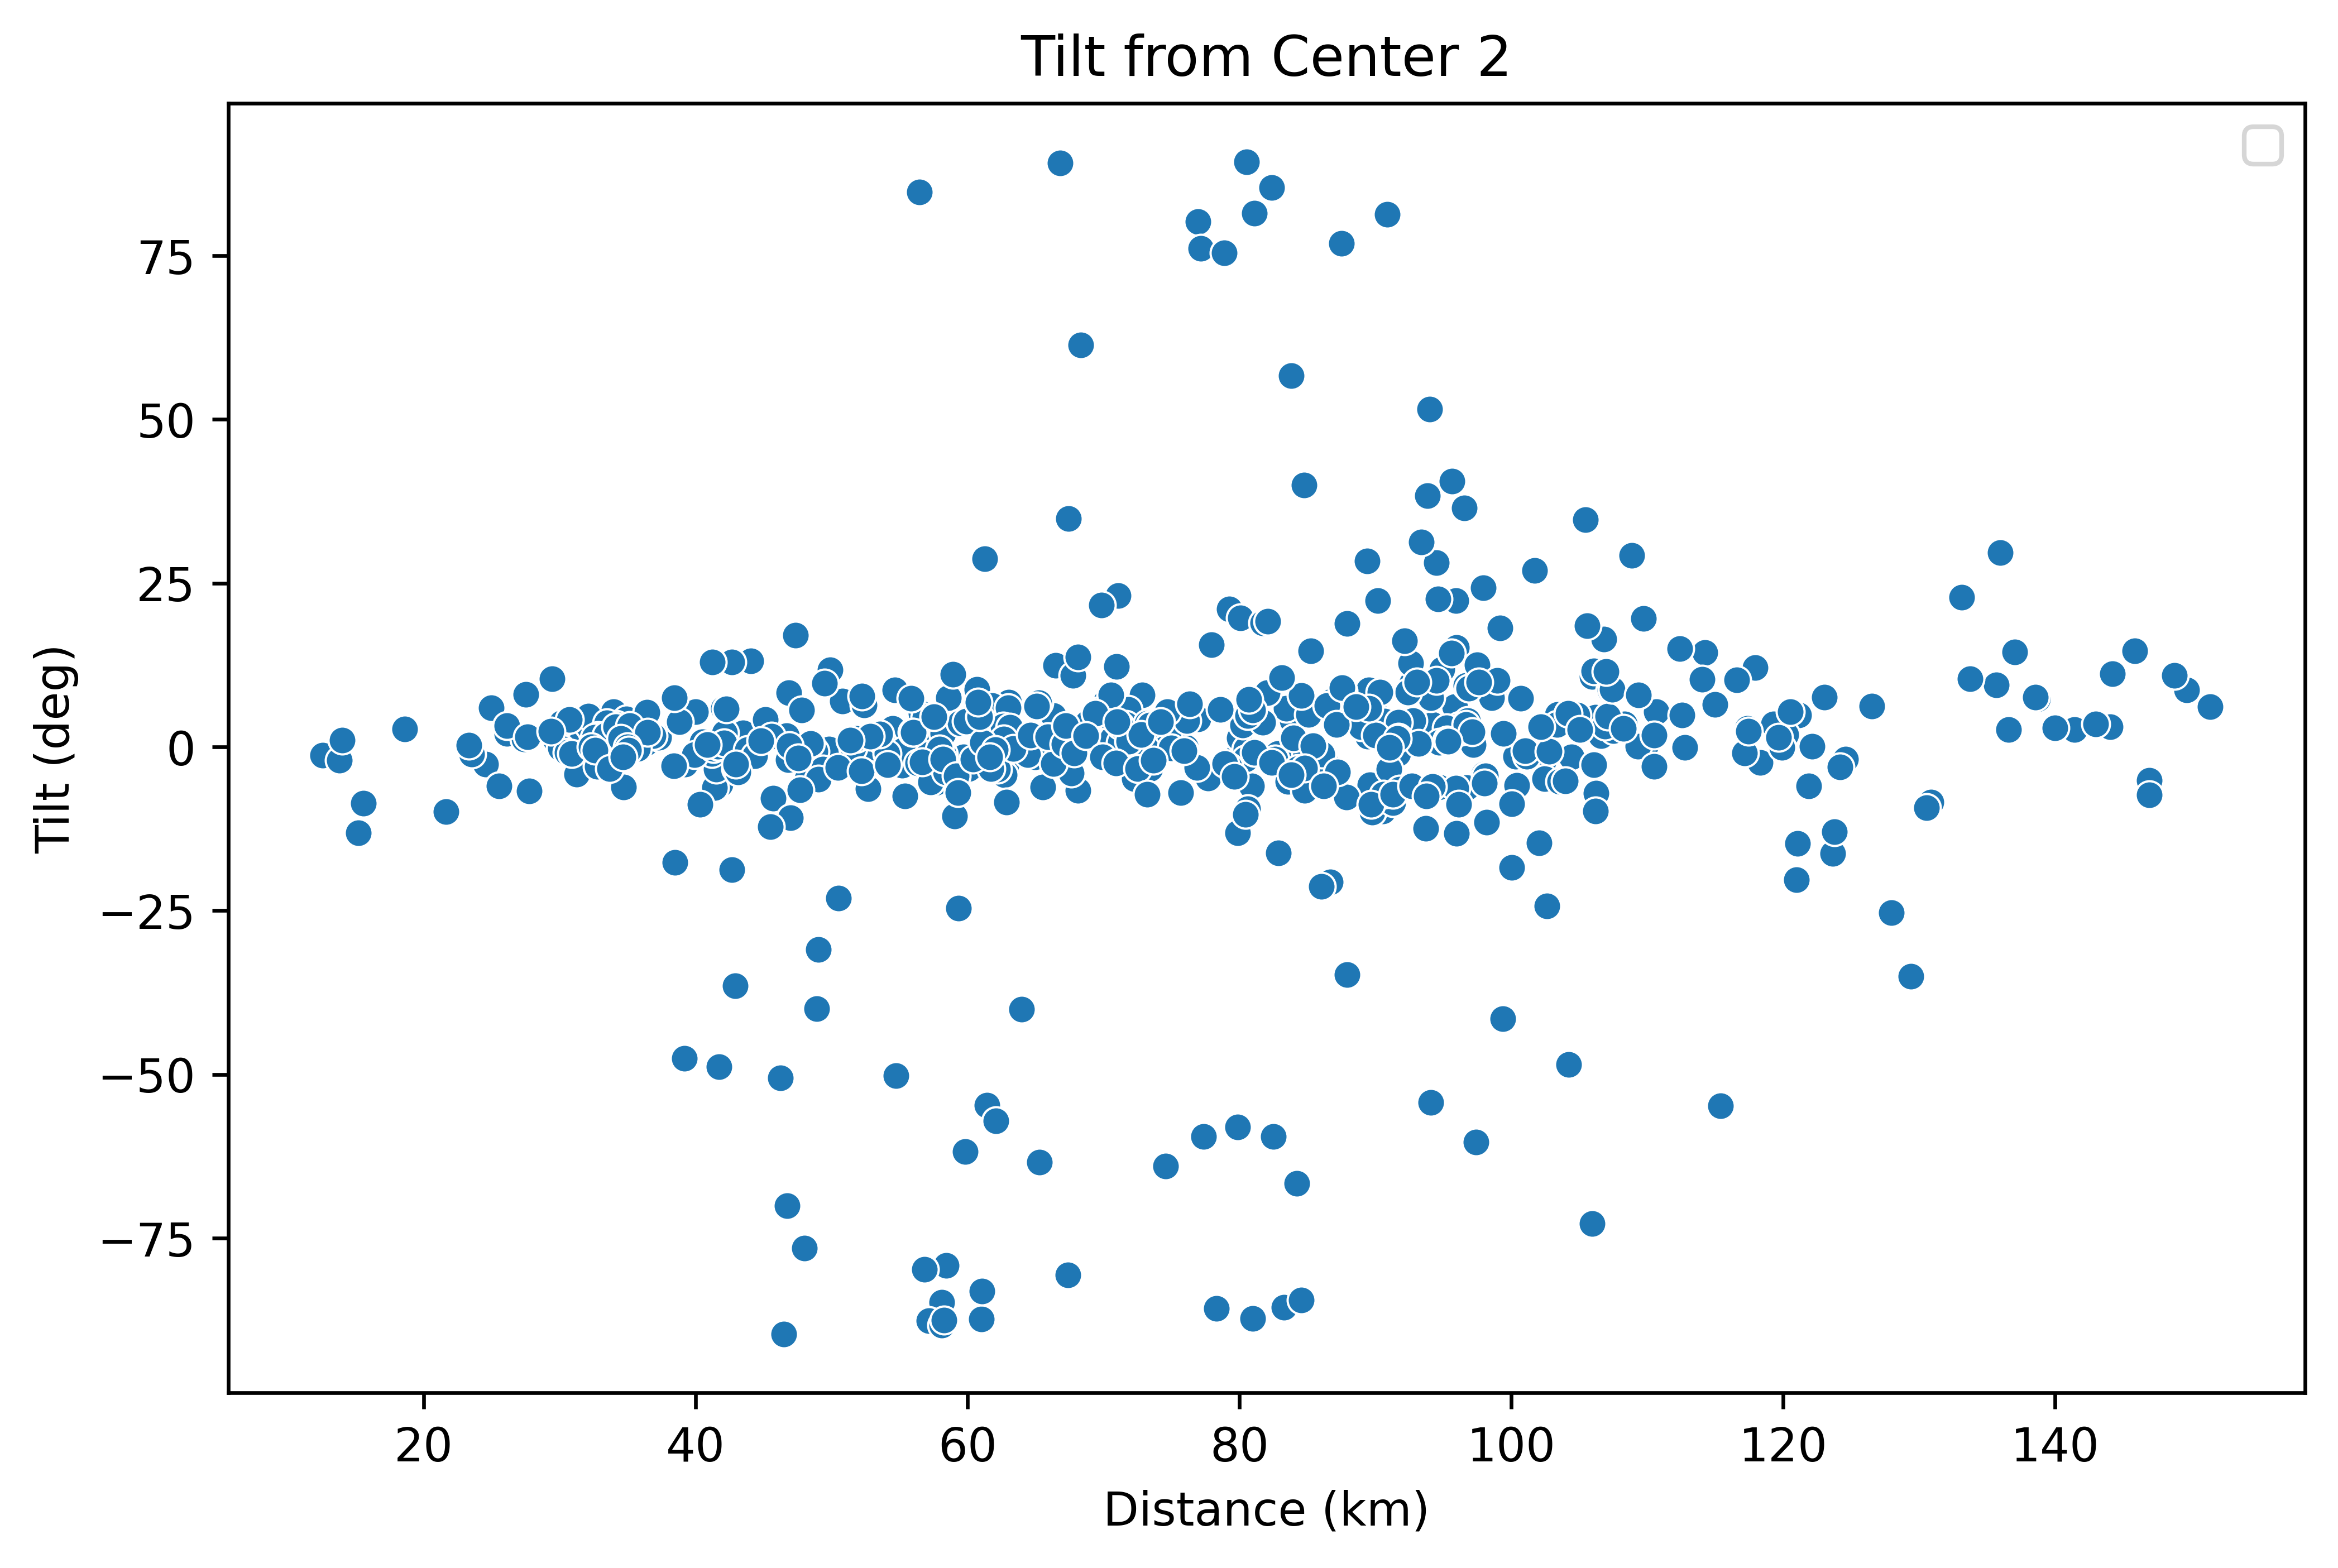

In [49]:
test_sweep.plot()
centers_calc[1].plot()

Define a function for plotting map and model data together.

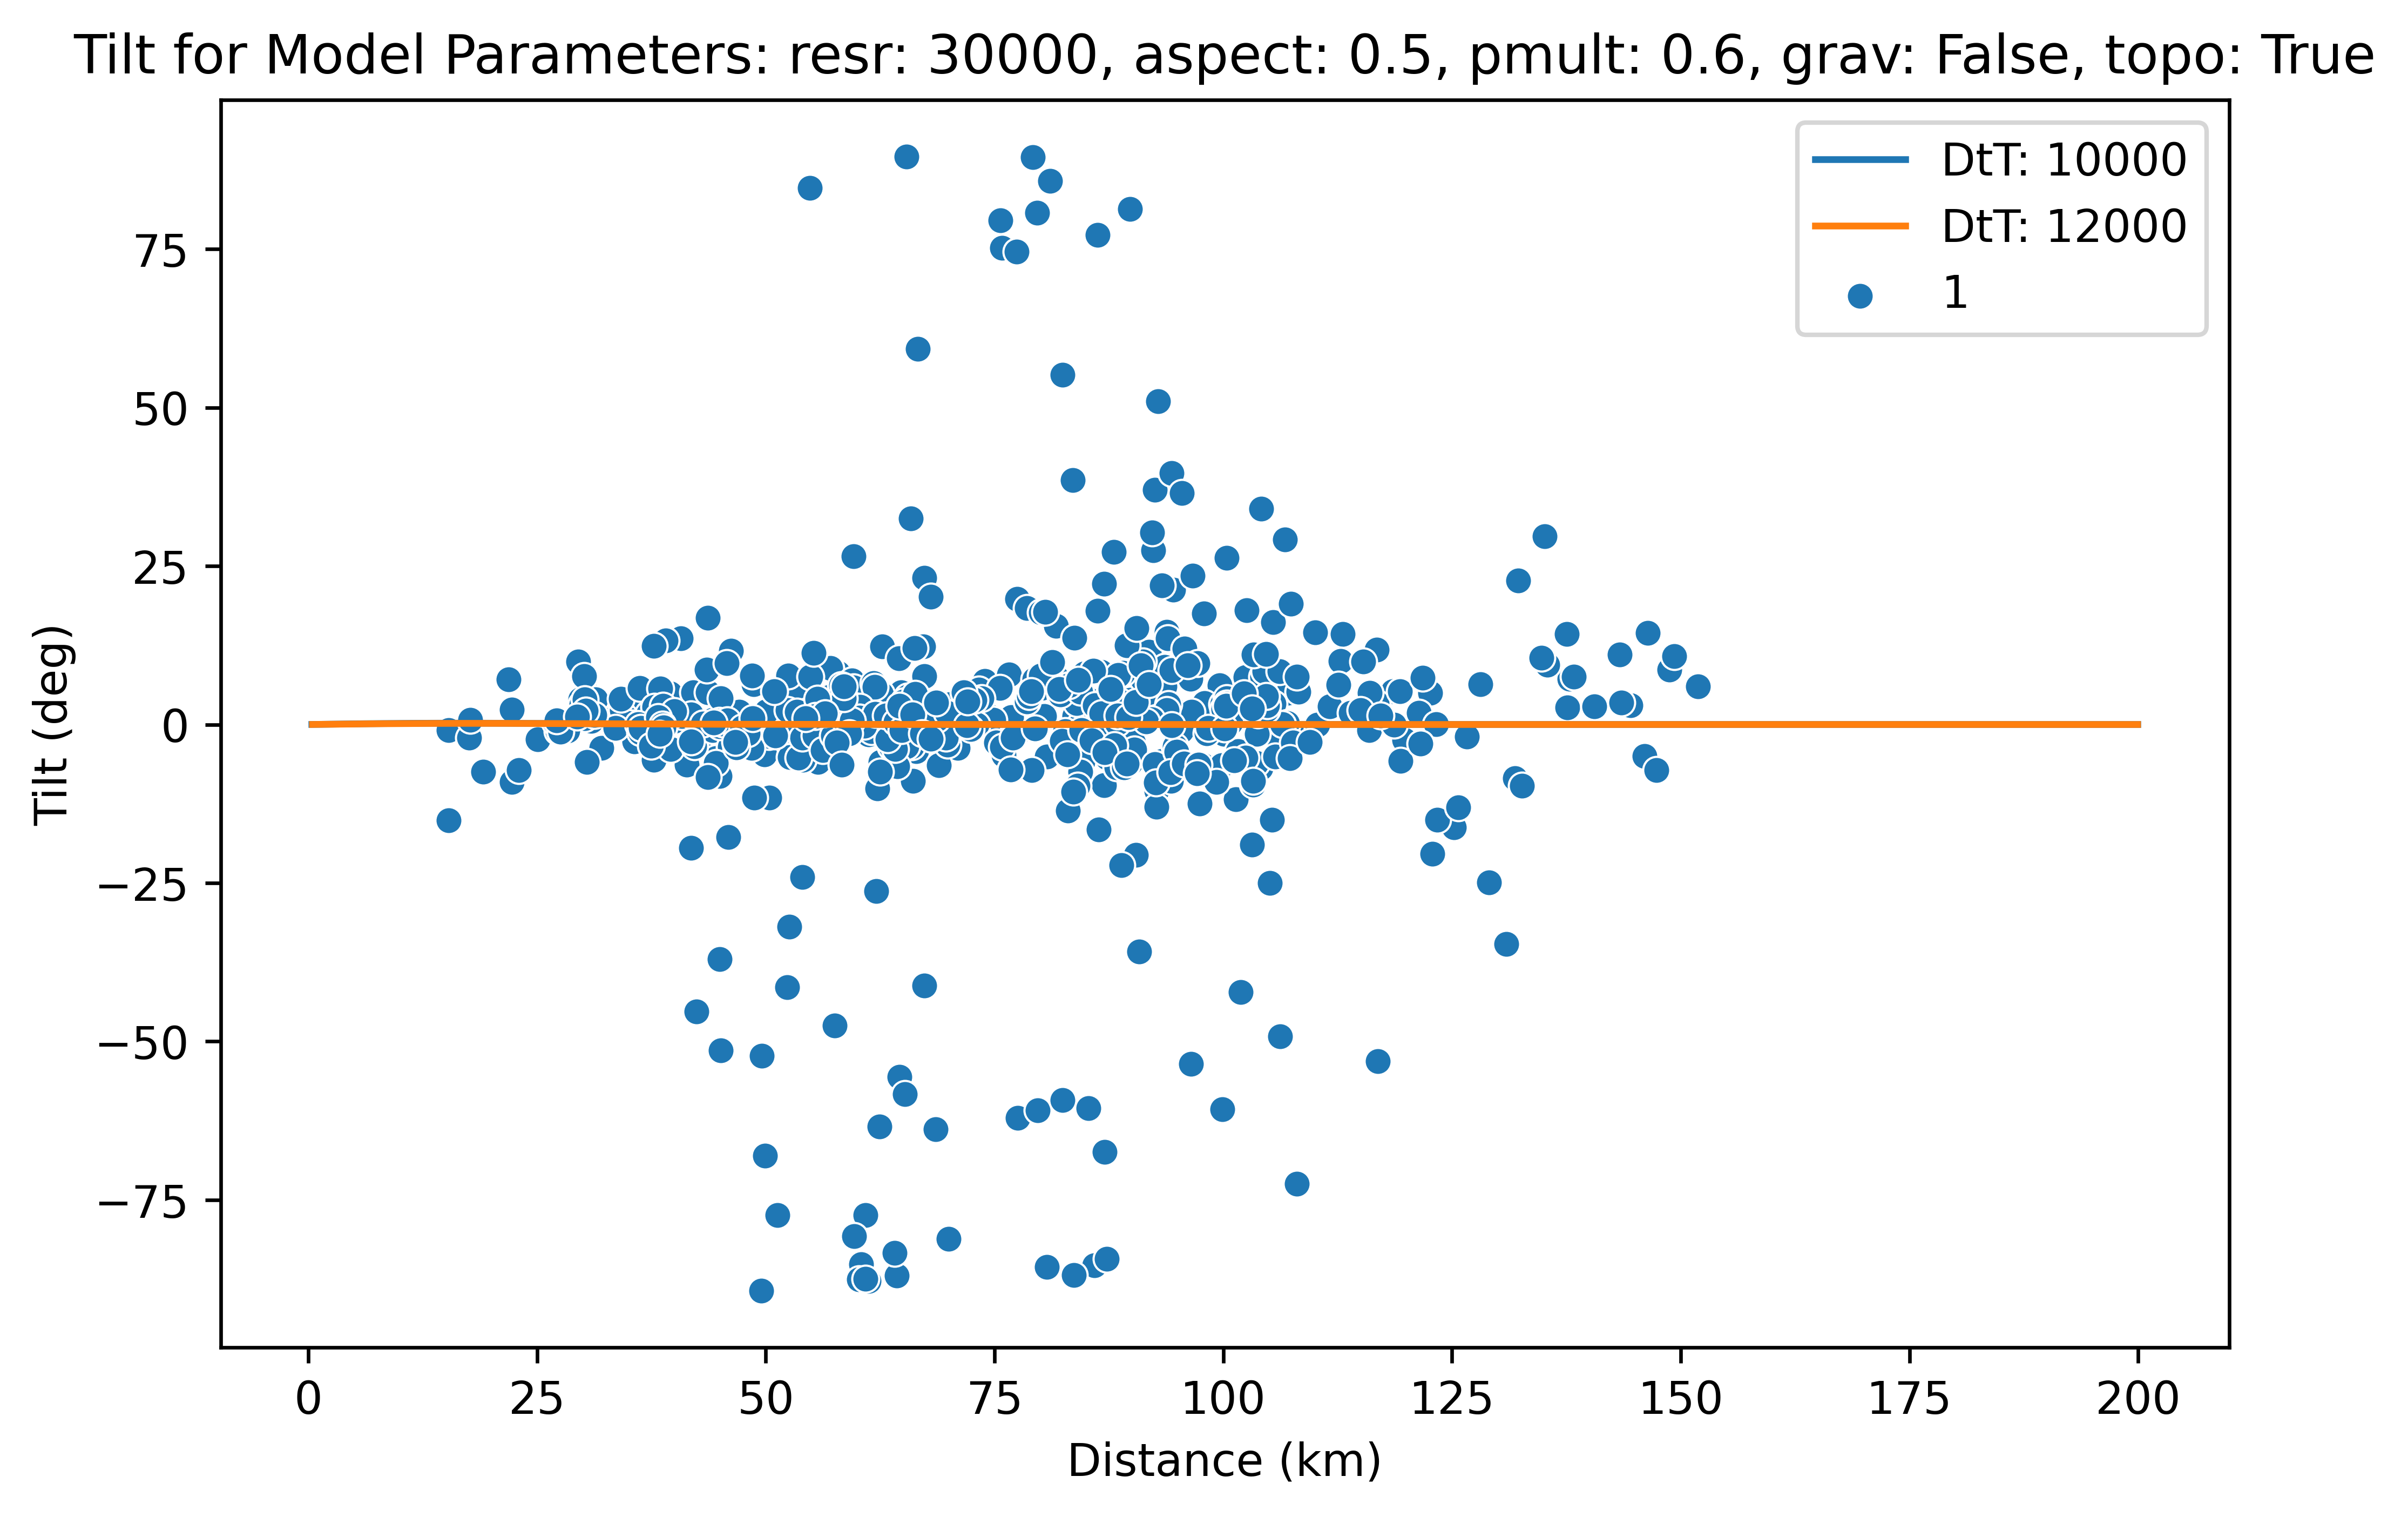

In [40]:
def combined_plot(sweep: ParamSweep, centers: list[Center], name: str = None): # type: ignore
    fig = plt.figure(figsize=(8, 5), dpi=600)

    for model in sweep.models:
        label = '{}'.format({param: model.params[param] for param in sweep.variables})
        label = label.replace("{", "")
        label = label.replace("}", "")
        label = label.replace("'", "")
        sns.lineplot(data=model.attributes, y="tilt", x="r2_km", label=label)

    for center in centers:
        sns.scatterplot(data=center.data, x='DIST', y='TILT', label=center.cID)

    model_title = f'{sweep.constants}'
    model_title = model_title.replace("{", "")
    model_title = model_title.replace("}", "")
    model_title = model_title.replace("'", "")
    plt.title(f"Radial Tilt: {model_title}")

    plt.title(f"Tilt for Model Parameters: {model_title}")
    plt.xlabel("Distance (km)")
    plt.ylabel("Tilt (deg)")
    plt.legend()

    # save plot with name if passed as argument
    if name is not None:
        fig.savefig("plot.svg")
        renderPDF.drawToFile(svg2rlg("plot.svg"), f"figures/{name}.pdf")
        os.remove("plot.svg")

combined_plot(test_sweep, [centers_calc[0]])